In [1]:
#Useful packages 
import matplotlib.pyplot as plt
from scipy.io import wavfile
import subprocess
import os
import scipy as sp
from scipy import signal
import math
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
import pandas as pd
from pysndfx import AudioEffectsChain
import python_speech_features
import seaborn as sns 
sns.set()
sns.set_style('whitegrid',{'axes.grid':False})



In [2]:
from pydub import AudioSegment
from os import walk

def convert_mp3_to_wav(direc,convert=False):
    
    f = []
    dirname=[]
    for (dirpath, dirnames, filenames) in walk(direc):
        f.extend(filenames)
        dirname.extend(dirpath)
        break
    if (convert):
        for i in f:    
            sound = AudioSegment.from_mp3(direc+i)
            sound.export(direc+i[:-4]+".wav", format="wav")
    return f

In [3]:
def finding_name_files(dictionnaire,name):
    lower_cast_name=name.lower()
    return [name for name, low_name in dictionnaire.items() if low_name == lower_cast_name]

## Feature Extraction of birds based on MFCC : 

In [4]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

In [5]:
def extract_features(parent_dir,file_ext=".wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []

    pos={}
    nb=0
    nb_prev=0
    k=0
    
    for count in range(name_file.shape[0]):
        
        fn = os.path.join(parent_dir,finding_name_files(dictionnaire,name_file[count]+file_ext)[0])
        
        # Load audio clip into librosa
        sound_clip,s = librosa.load(fn)
        
        # Normalize audio
        sound_clip_normalized = librosa.util.normalize(sound_clip)
        
        # Split audio time series into non-silent sections
        split_array = librosa.effects.split(sound_clip_normalized, top_db=10, frame_length=32768, hop_length=256)
        split_chirps = []
        
        # Reform a single time series from the separate non-silent components
        for i,interval in enumerate(split_array):
            split_chirps.append(librosa.effects.remix(sound_clip_normalized, intervals=[interval]))
        
        # Loop through each individual audio segment (bird chirp) and apply MFCC to generate features
        k=0
        for i, audio_segment in enumerate(split_chirps):

            for (start,end) in windows(audio_segment,window_size):
                start = int(start)
                end = int(end)
                if(len(audio_segment[start:end]) == window_size):
                    signal = audio_segment[start:end]
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    k=k+1
        nb_prev=nb
        nb=nb+k        
        pos[finding_name_files(dictionnaire,name_file[count]+file_ext)[0]]=(nb_prev,nb)

    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features),pos


In [6]:
parent_dir = 'ALL_BIRDS_WAV/'
sample_DF=pd.read_csv('../AllBirdsv4.csv')

name_file=sample_DF['English_name']+'-'+sample_DF['File ID'].apply(str)
name_file=name_file.replace(' ', '-',regex=True)
name_file=name_file[:6]

dictionnaire={}
wav_files = []
for root, dirs, files in os.walk("ALL_BIRDS_WAV/"):  
    for filename in files:
        wav_files.append(filename)
for file in wav_files:
    dictionnaire[file]=str(file).lower()

Species_ID = sample_DF.English_name.factorize()[0]
sample_DF['Species_ID'] = Species_ID
features, pos_train= extract_features(parent_dir)

### Some representation of MFCCs of blue pepits:

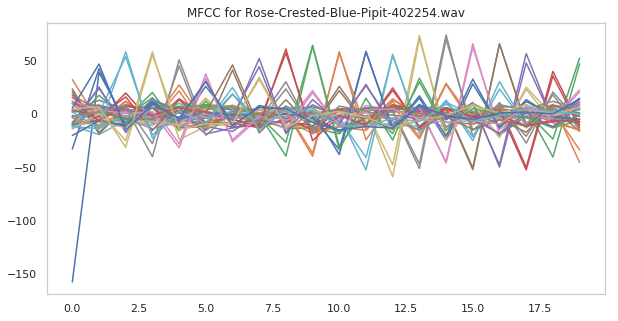

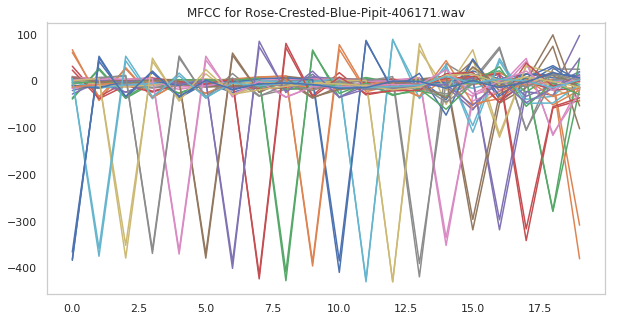

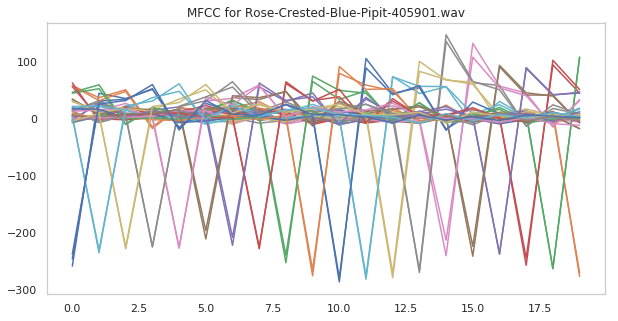

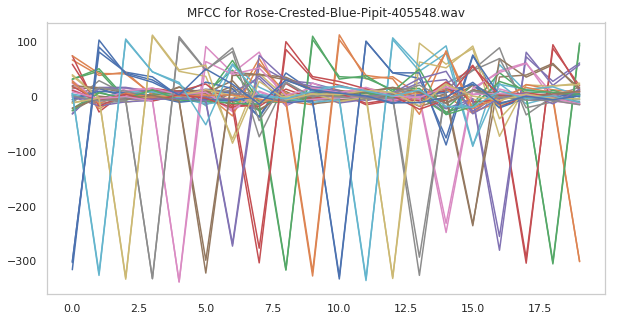

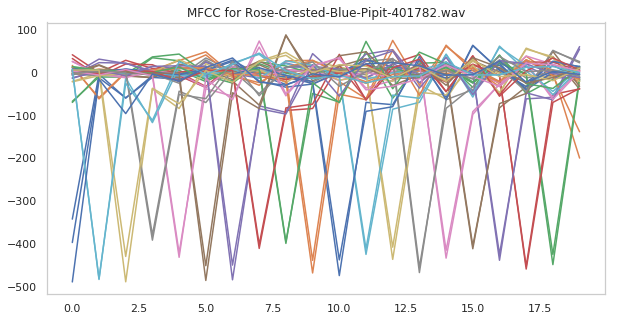

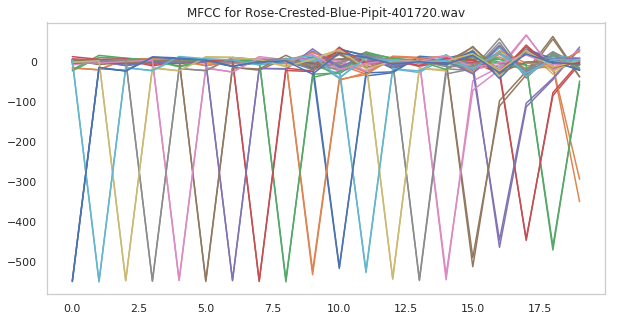

In [7]:
def ix(dic, n): 
    return list(dic)[n]
for i in range(len(pos_train)):
    plt.figure(figsize=(10,5))
    plt.plot(features[pos_train[ix(pos_train,i)][0]])
    plt.title('MFCC for '+ix(pos_train,i))
    plt.show()

## Feature Extraction - Kasios Predictions :

In [8]:
def extract_features_pred(parent_dir,file_ext=".wav",bands = 20, frames = 41):
    window_size = 512 * (frames - 1)
    mfccs = []

    nb=0
    nb_prev=0
    k=0
    pos={}
    
    for id in range(1,16): 
        fn = os.path.join(parent_dir, str(id) + file_ext)
        sound_clip,s = librosa.load(fn)
                
        split_array = librosa.effects.split(sound_clip, top_db=10, frame_length=32768, hop_length=256)

        split_chirps = []
        
        for i,interval in enumerate(split_array):
            split_chirps.append(librosa.effects.remix(sound_clip, intervals=[interval]))
        
        
        remixed_split = librosa.effects.remix(sound_clip, intervals=librosa.effects.split(sound_clip, top_db=10, frame_length=32768, hop_length=256))

        k=0
        for i, audio_segment in enumerate(split_chirps):

            for (start,end) in windows(audio_segment,window_size):
                start = int(start)
                end = int(end)

                if(len(audio_segment[start:end]) == window_size):
                    signal = audio_segment[start:end]
                    mfcc = librosa.feature.mfcc(y=signal, sr=s, n_mfcc = bands).T.flatten()[:, np.newaxis].T
                    mfccs.append(mfcc)
                    k=k+1

        nb_prev=nb
        nb=nb+k        
        pos[id]=(nb_prev,nb)

    features = np.asarray(mfccs).reshape(len(mfccs),bands,frames)
    return np.array(features),pos

In [9]:
convert_mp3_to_wav("../Test Birds from Kasios/",convert=False);
data_dir = "../Test Birds from Kasios/"
kasios_features,pos= extract_features_pred(data_dir)

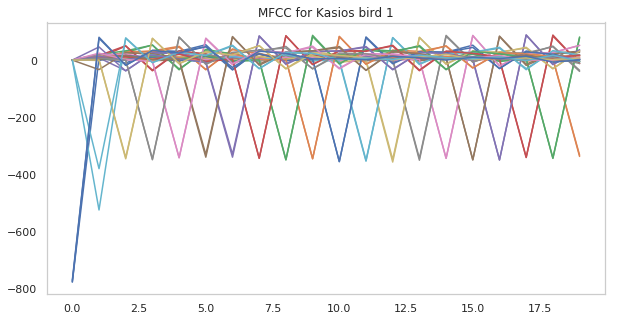

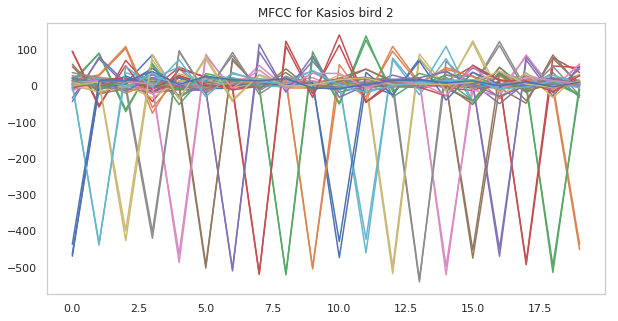

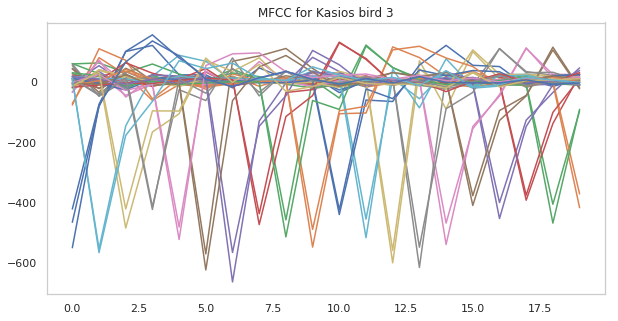

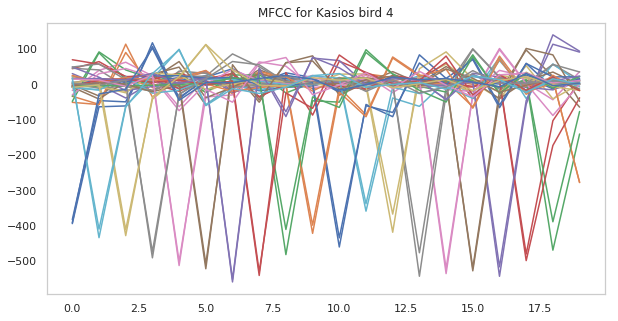

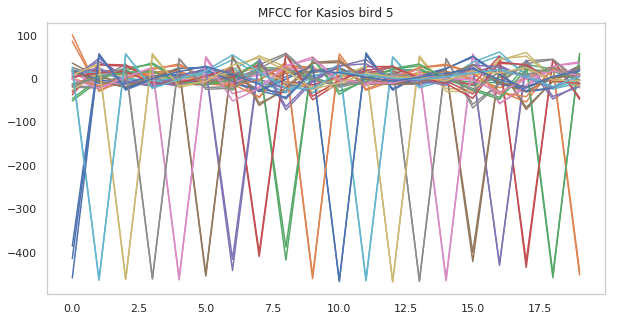

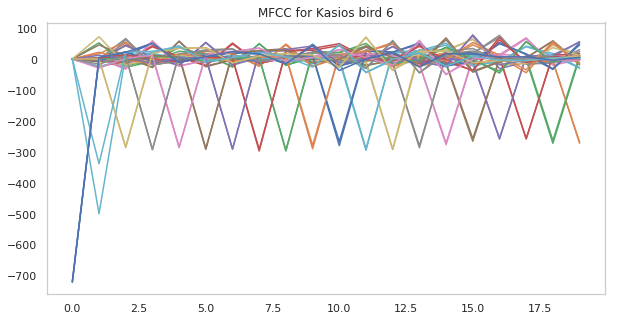

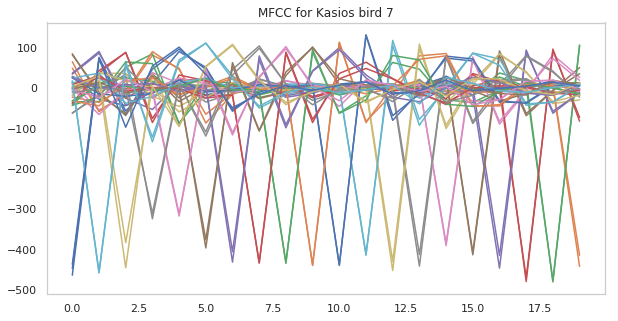

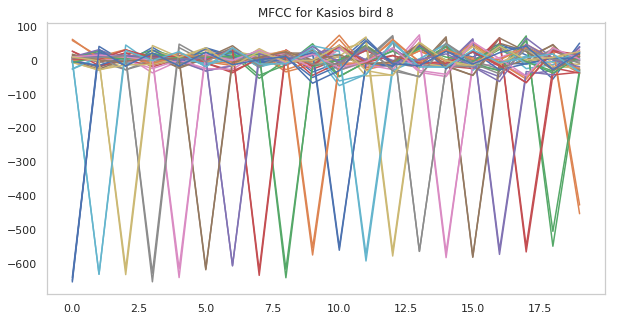

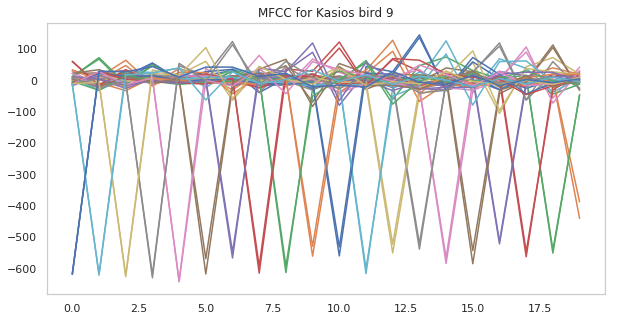

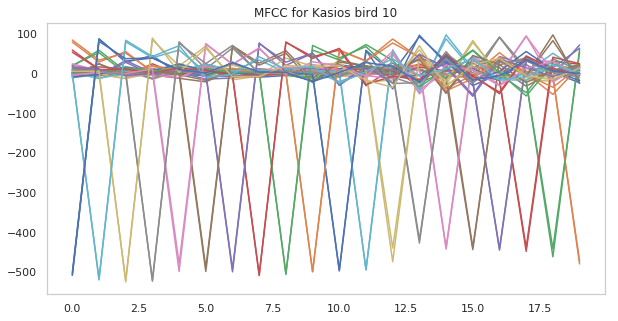

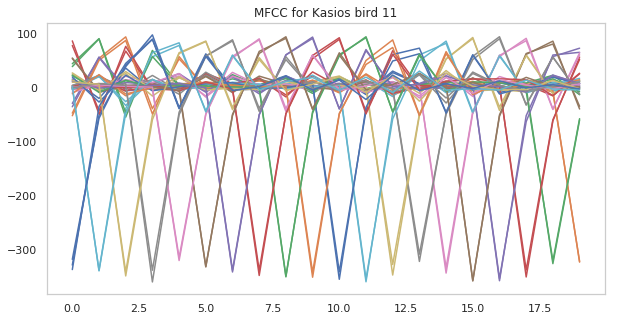

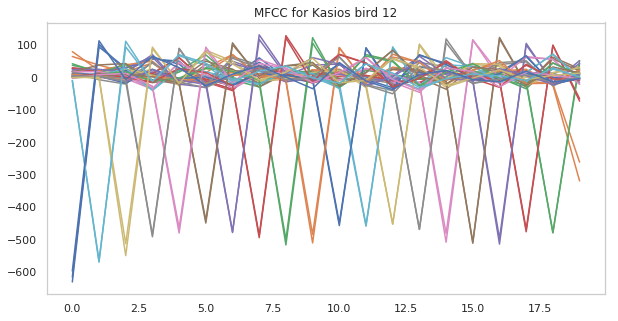

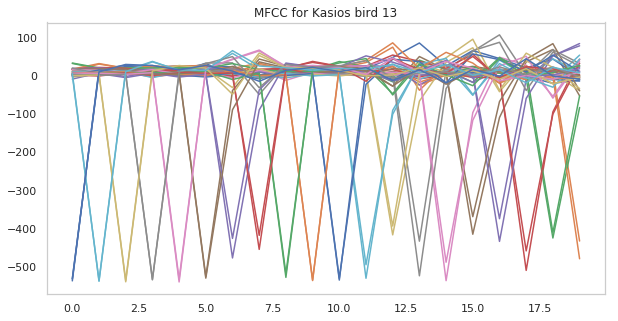

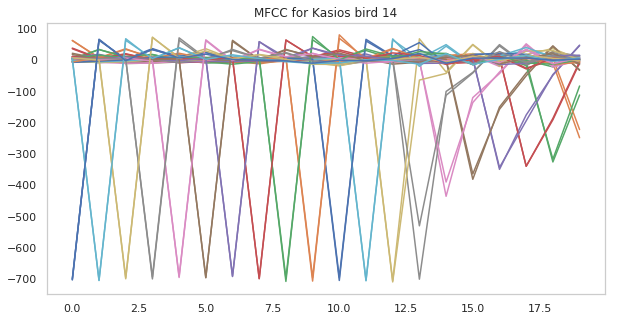

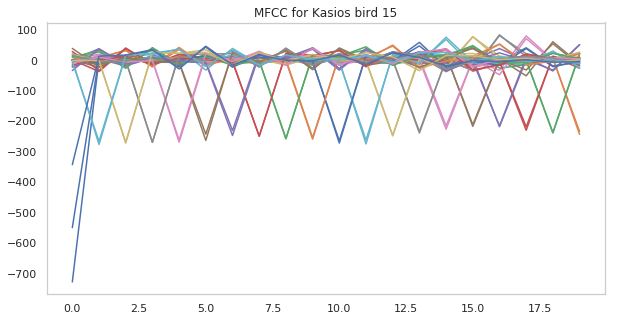

In [10]:
import matplotlib.pyplot as plt
for i in range(1,16):
    plt.figure(figsize=(10,5))
    plt.plot(kasios_features[pos[i][0]])
    plt.title('MFCC for Kasios bird '+str(i))
    plt.show()
